In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm 
from datetime import date 
from datetime import datetime

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
file_dir = '../'

data_dir = file_dir + 'test_data/'
result_dir = data_dir + 'results/'

In [3]:
# !pip install pyspellchecker

%load_ext autoreload
%autoreload 2

# %run '/content/drive/My Drive/Colab Data/public_app_analysis/utils/publicAnalysisHelper.py'
%run ../references/food_modelling_utils.py
%run ../foodparser/foodparser.py

[nltk_data] Downloading package words to /Users/joey-hou/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/joey-
[nltk_data]     hou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/joey-
[nltk_data]     hou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/joey-hou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# !pip install indexer

In [5]:
data_dir

'../test_data/'

# Loading food parser

In [6]:
fp = FoodParser()
# len(fp.all_gram_set)

In [7]:
# combined_df = pd.read_csv(data_dir + 'food_annotations/combined_df.csv')
# combined_df.head()

In [8]:
# food_type_dict = {}
# weird_keys = []
# for sett in fp.all_gram_set:
#     for key in sett:
#         if key not in combined_df.gram_key.values:
#             continue
#         if combined_df.query('gram_key == "' + key + '"').shape[0] == 1:
#             food_type_dict[key] = combined_df.query('gram_key == "' + key + '"').food_type.values[0]
#         else:
#             weird_keys.append(key)

In [9]:
# pd.DataFrame(weird_keys).to_csv('weird_keys.csv', index = False)

In [10]:
# 'yoghurt' in fp.all_gram_set[0]

- **After manual annotations**

In [11]:
# weird_csv = pd.read_csv(data_dir + 'food_annotations/weird_keys.csv')
# weird_csv.head()

In [12]:
# weird_csv.index = weird_csv.key
# weird_key_food_type_mask = dict(weird_csv.food_type)

In [13]:
# combined_df.food_type = combined_df.apply(lambda s: s.food_type if s.gram_key not in weird_key_food_type_mask.keys() else \
#                                          weird_key_food_type_mask[s.gram_key], axis = 1)

In [14]:
# combined_df = combined_df.drop_duplicates()
# combined_df.index = combined_df.gram_key
# food_type_dict = dict(combined_df.food_type)

In [15]:
# pickle.dump(food_type_dict, open(data_dir + 'food_annotations/final_database/food_type_dict.pickle', 'wb'))

In [16]:
# combined_df.food_type.unique()

In [17]:
# combined_df.food_type = combined_df.food_type.apply(lambda x: x.strip())
# combined_df.shape

In [18]:
# combined_df.to_csv(data_dir + 'food_annotations/final_database/combined_df.csv', index = False)

# Parse Public Food Data
## Load in raw data

### Option 1: public baseline data

In [14]:
public_all_pickle_file = open(data_dir + 'raw/public_0924_basline_usable_expanded.pickle', 'rb')
public_all = pickle.load(public_all_pickle_file).reset_index(drop = True)
public_all.head(2)

,ID,unique_code,research_info_id,desc_text,food_type,original_logtime,original_logtime_notz,day,local_time,time,week_from_start,year
0,282,alqt15090005,150,Water,w,09-09-2015 8:20PM JST,2015-09-09 20:20:00,2015-09-09,20.333333,20:20:00,1,2015
1,283,alqt15090005,150,Soup,f,09-09-2015 10:38PM JST,2015-09-09 22:38:00,2015-09-09,22.633333,22:38:00,1,2015


In [15]:
# public_all[['desc_text', 'food_type']].iloc[:10000].to_csv('~/Desktop/sample_data.csv', index = False)

In [16]:
# pickle.load(open(data_dir + 'public_app_analysis/data/public_0924_basline_usable_expanded.pickle', 'rb')).shape

In [17]:
public_all.shape # In baseline, there are 1,648,792 records

(1653926, 12)

In [122]:
# sample_df = public_all.query('food_type in ["f", "b"]').sample(5000).reset_index(drop = True)
# public_all.query('food_type in ["f", "b"]').shape

(1153330, 12)

In [30]:
# fp = FoodParser()
# parsed = [fp.parse_food(i) for i in tqdm(public_all.desc_text.values)]

### Option 2: firefighter all period data

In [33]:
firefighter_data_pickle_file = open(data_dir + 'raw/FFFoodData_Unique_Time_All_Aug2020.pickle', 'rb')
firefighter_data = pickle.load(firefighter_data_pickle_file).reset_index(drop = True)
firefighter_data = firefighter_data.rename(columns = {'PID': 'unique_code'})
firefighter_data.head(2)

,unique_code,caloric,day,desc_text,food_type,local_time,original_logtime,original_logtime_notz,participant,study,time,tz
0,9bbi18050004,1,2018-07-18,kind bar && coffee,f,9.583333,07-18-2018 09:35AM PDT,2018-07-18 09:35:00,Hero-001,TRE,09:35:00,PDT
1,9bbi18050004,1,2018-06-24,potatoe,f,19.116667,06-24-2018 07:07PM PDT,2018-06-24 19:07:00,Hero-001,TRE,19:07:00,PDT


In [34]:
firefighter_data.shape
# if 'ID' not in firefighter_data:
#     firefighter_data['ID'] = range(firefighter_data.shape[0])
# firefighter_data

(109712, 12)

In [54]:
public_all = firefighter_data

## Pre-processing / expansion

In [18]:
all_entries = []
for idx in tqdm(range(public_all.shape[0])):
    logging = public_all.desc_text.values[idx]
    if ',' in logging:
        for entry in logging.split(','):
            all_entries.append({
                'food_type': public_all.food_type.values[idx],
                'desc_text': entry,
                'unique_code': public_all.unique_code.values[idx]
            })
    else:
        all_entries.append({
            'food_type': public_all.food_type.values[idx],
            'desc_text': logging,
            'unique_code': public_all.unique_code.values[idx]
        })

100%|██████████| 1653926/1653926 [00:32<00:00, 51076.73it/s]


In [88]:
public_all_expanded = pd.DataFrame(all_entries)
public_all_expanded = public_all_expanded.query('food_type in ["f", "b"]')
public_all_expanded.shape

(1793963, 3)

In [90]:
public_all_expanded.head()

,food_type,desc_text,unique_code
1,f,Soup,alqt15090005
2,b,Yogurt,alqt15090005
3,f,Spagetti,alqt15090005
4,f,Spaghetti,alqt15090005
5,f,Yogurt,alqt15090005


## **Initialized foodparser**

In [91]:
fp = FoodParser()
fp.initialization()
# fp.all_gram_set[0].add('yoghurt')

In [92]:
'yoghurt' in fp.all_gram_set[0]

True

In [93]:
'latte' in fp.all_gram_set[0]

True

In [94]:
'red pepper' in fp.food_type_dict.keys()

True

In [95]:
'curcumin' in fp.food_type_dict.keys()

True

## **Parsing**

In [96]:
sample_df = public_all_expanded
# sample_df = public_all_expanded.query('food_type in ["f", "b"]').reset_index(drop = True)
sample_df.shape

(1793963, 3)

In [97]:
total_unknown = 0
total_token = 0
parsed = []
total_unknown_tokens = []
counter = 0
for i in tqdm(range(sample_df.shape[0])):
    entry = sample_df.iloc[i].desc_text
    result, num_token, num_unknown, unknown_tokens = fp.parse_food(entry, return_sentence_tag = True)
    result = [(f, fp.find_food_type(f)) for f in result]
    parsed.append(result)
    total_token += num_token
    total_unknown += num_unknown
    total_unknown_tokens += unknown_tokens
    
#     counter += 1
#     if counter == 50:
#         break

100%|██████████| 1793963/1793963 [11:26<00:00, 2614.23it/s]


In [98]:
# total_unknown_tokens

## Parsing results

In [110]:
public_all_parsed = pd.DataFrame({
    'food_type': sample_df.food_type.values,
    'desc_text': sample_df.desc_text.values,
    'cleaned': parsed
})
public_all_parsed.head(2)

,food_type,desc_text,cleaned
0,f,Soup,"[(soup, f)]"
1,b,Yogurt,"[(yogurt, b)]"


In [111]:
# public_all_parsed.to_csv(result_dir + 'public_baseline_all_parsed.csv', index = False)
# public_all_parsed.to_csv(result_dir + 'firefighter_all_parsed.csv', index = False)

In [112]:
# public_all_parsed = pd.read_csv(result_dir + 'public_baseline_all_parsed.csv')
# public_all_parsed.shape

In [113]:
public_all_parsed.head(2)

,food_type,desc_text,cleaned
0,f,Soup,"[(soup, f)]"
1,b,Yogurt,"[(yogurt, b)]"


In [114]:
# public_all_parsed.loc[public_all_parsed.cleaned.apply(lambda x: len(x) > 1)]

In [115]:
all_unknown_phrases_df = pd.DataFrame([ph.strip() for ph in total_unknown_tokens], columns = ['unknown_phrases'])
# all_unknown_phrases_df.to_csv(result_dir + 'all_unknown_phrases.csv', index = False)

In [116]:
all_unknown_phrases_df.head(2)

,unknown_phrases
0,isotonic drink
1,sashimi


## Parsing Analysis
### Entry-level

In [117]:
parsed = public_all_parsed.cleaned.values
print('Number of un-catched entries:', len([lst for lst in parsed if len(lst) == 0])\
          , ', out of total entries of', len(parsed))
print('Proportion of un-catched entries:', len([lst for lst in parsed if len(lst) == 0]) / len(parsed))

Number of un-catched entries: 174314 , out of total entries of 1793963
Proportion of un-catched entries: 0.0971669984275038


In [118]:
unmatched_count = len(total_unknown_tokens)
totally_unmatched = len([(lst) for lst in public_all_parsed.cleaned.values if len(lst) == 0])
partially_unmatched = unmatched_count - totally_unmatched
totally_matched = public_all_parsed.shape[0] - unmatched_count

In [119]:
# Totally un-matched
print('Totally unmatched entries count:', totally_unmatched)

# Partially un-matched
print('Partially unmatched entries count:', partially_unmatched)

# Totally matched
print('Totally matched entries count:', totally_matched)

Totally unmatched entries count: 174314
Partially unmatched entries count: 427637
Totally matched entries count: 1192012


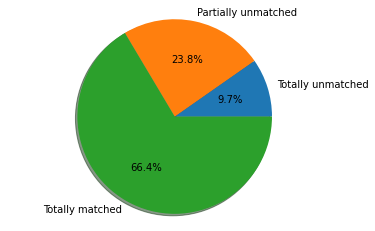

In [120]:
# pie chart of workers
labels = ['Totally unmatched', 'Partially unmatched', 'Totally matched']
sizes = [totally_unmatched, partially_unmatched, totally_matched]

# print(sizes) # adds up to 1433, which is the total number of participants
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

### **Token level**

In [121]:
total_unknown / total_token

0.22997745327932068

In [104]:
total_token

4079124

In [105]:
total_unknown_tokens = [s.strip() for s in total_unknown_tokens]

In [106]:
total_unknown_tokens[:20]

['isotonic drink',
 'sashimi',
 'abalone',
 'oolong',
 'sake ml',
 'pike conger deep fly',
 'yakuzen',
 'asparagas',
 'iced',
 'energy bar',
 'drink',
 'cold',
 'ball',
 'natto',
 'plant chopped',
 'snack',
 'miso',
 'french fried',
 'ceaser',
 'margerita']

In [116]:
'veg' in total_unknown_tokens

True

In [122]:
tmp_negative_samples = ['snacks', 'dinner', 'ml', 'lunch', 'breakfast', 'veg', 'drink', 'glass water', 'bulletproof coffee']
tmp_negative_samples = set(tmp_negative_samples)

unparsed = public_all_parsed.desc_text.values

neg_entry = 0
for u in tqdm(unparsed):
    cleaned = fp.handle_all_cleaning(u)
    if cleaned in tmp_negative_samples:
        neg_entry += 1

100%|██████████| 2399626/2399626 [00:55<00:00, 42955.38it/s]


In [123]:
neg_entry

22197

In [107]:
len(total_unknown_tokens)

865624

In [108]:
pd.Series(total_unknown_tokens).value_counts().head(500).sum()

420484

/Users/joey-hou/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


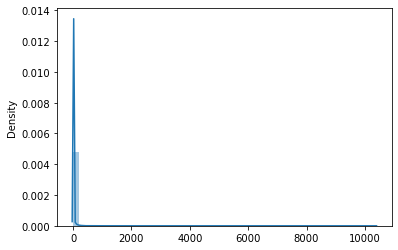

In [109]:
sns.distplot(pd.Series(total_unknown_tokens).value_counts())

In [110]:
uncatched_tokens = pd.DataFrame(pd.Series(total_unknown_tokens).value_counts(), columns = ['counts'])\
    .query('counts >= 50')
uncatched_tokens.head(20)

,counts
ml,10365
herbal,7482
breakfast,5925
white,5684
dinner,5460
sauce,5338
lunch,5085
red,4653
c,4531
g,4384


In [111]:
unigram = []
bigram = []
for phrase in tqdm(total_unknown_tokens):
    if len(phrase) == 1:
        unigram.append(phrase)
    else:
        for bi in nltk.bigrams(phrase.split()):
            bigram.append(bi)

100%|██████████| 865624/865624 [00:01<00:00, 734867.53it/s]


In [52]:
total_unknown_tokens[2]

'uttar vermicelli'

In [53]:
list(nltk.bigrams(total_unknown_tokens[2].split()))

[('uttar', 'vermicelli')]

In [56]:
bigram[:3]

[('uttar', 'vermicelli'), ('fermented', 'soya'), ('daim', 'bar')]

In [57]:
cfreq_2gram = nltk.ConditionalFreqDist(bigram)

In [ ]:
# dict(cfreq_2gram)

In [27]:
uncatched_tokens.to_csv(result_dir + 'uncatched_tokens.csv')

# Analysis on parsing result and the uncatched tokens

In [201]:
public_all_parsed.shape

(100000, 4)

In [204]:
f_count, f_lst = 0, []
b_count, b_lst = 0, []
o_count, o_lst = 0, []
for i in tqdm(range(public_all_parsed.shape[0])):
    food_lst = public_all_parsed.cleaned.values[i]
    for f in food_lst:
        if f[1] == 'f':
            f_count += 1
            f_lst.append(f[0])
        elif f[1] == 'b':
            b_count += 1
            b_lst.append(f[0])
        else:
            o_count += 1
            o_lst.append(f[0])

100%|██████████| 100000/100000 [00:00<00:00, 150478.24it/s]


In [205]:
f_count, b_count, o_count

(126936, 43748, 7096)

In [208]:
pd.Series(f_lst).value_counts(), pd.Series(b_lst).value_counts(), pd.Series(o_lst).value_counts()

(egg                     3900
 cheese                  3518
 chicken                 3096
 banana                  2814
 rice                    2514
                         ... 
 vegan oatmeal cookie       1
 turkey sandwich chip       1
 greek chicken salad        1
 baked veggie               1
 naan                       1
 Length: 579, dtype: int64,
 coffee                          9377
 tea                             4715
 salad                           3574
 milk                            3443
 black coffee                    1648
                                 ... 
 strawberry banana smoothie         1
 cold brew coffee almond milk       1
 irish tea                          1
 kombucha chia seed                 1
 sugar syrup                        1
 Length: 110, dtype: int64,
 chocolate            1927
 almond               1442
 water                1365
 orange                832
 yoghurt               671
 turmeric              302
 vitamin               275
 rose  

# Parse Firefighters Data

In [10]:
firefighter_data_pickle_file = open(data_dir + 'fire_fighter/FFFoodData_Unique_Time_All_Aug2020.pickle', 'rb')
firefighter_data = pickle.load(firefighter_data_pickle_file)
firefighter_data.head(2)

,PID,caloric,day,desc_text,food_type,local_time,original_logtime,original_logtime_notz,participant,study,time,tz
1,9bbi18050004,1,2018-07-18,kind bar && coffee,f,9.583333,07-18-2018 09:35AM PDT,2018-07-18 09:35:00,Hero-001,TRE,09:35:00,PDT
2,9bbi18050004,1,2018-06-24,potatoe,f,19.116667,06-24-2018 07:07PM PDT,2018-06-24 19:07:00,Hero-001,TRE,19:07:00,PDT


In [30]:
firefighter_data.query('food_type == "m"').shape

(1704, 13)

In [11]:
firefighter_data.shape

(109712, 12)

In [13]:
fp = FoodParser()

# fp.all_gram_set[0].add('yoghurt')

'yoghurt' in fp.all_gram_set[0]

True

In [14]:
sample_df = firefighter_data
if 'ID' not in sample_df:
    sample_df['ID'] = range(sample_df.shape[0])

total_unknown = 0
total_token = 0
parsed = []
total_unknown_tokens = []
for i in tqdm(range(sample_df.shape[0])):
    entry = sample_df.iloc[i].desc_text
    result, num_token, num_unknown, unknown_tokens = fp.parse_food(entry, return_sentence_tag = True)
    result = [(f, fp.find_food_type(f)) for f in result]
    parsed.append(result)
    total_token += num_token
    total_unknown += num_unknown
    total_unknown_tokens += unknown_tokens

100%|██████████| 109712/109712 [11:04<00:00, 165.08it/s]


In [15]:
total_unknown / total_token

0.1891221362609441

In [19]:
ff_all_parsed = pd.DataFrame({
    'ID': sample_df.ID,
    'food_type': sample_df.food_type.values,
    'desc_text': sample_df.desc_text.values,
    'cleaned': parsed
})
ff_all_parsed.head(2)

,ID,food_type,desc_text,cleaned
1,0,f,kind bar && coffee,"[(kind bar, f), (coffee, b)]"
2,1,f,potatoe,"[(potato, f)]"


In [20]:
uncatched_tokens = pd.DataFrame(pd.Series(total_unknown_tokens).value_counts(), columns = ['counts']).query('counts >= 50')
uncatched_tokens

,counts
reggie,1615
bar,1333
grandma,1157
quinta,929
sauce,814
...,...
fillet,50
pop,50
chopped,50
levothyroxine,50


In [21]:
f_count, f_lst = 0, []
b_count, b_lst = 0, []
o_count, o_lst = 0, []
for i in tqdm(range(ff_all_parsed.shape[0])):
    food_lst = ff_all_parsed.cleaned.values[i]
    for f in food_lst:
        if f[1] == 'f':
            f_count += 1
            f_lst.append(f[0])
        elif f[1] == 'b':
            b_count += 1
            b_lst.append(f[0])
        else:
            o_count += 1
            o_lst.append(f[0])

100%|██████████| 109712/109712 [00:00<00:00, 171793.79it/s]


In [22]:
f_count, b_count, o_count

(151181, 39300, 3224)

In [24]:
pd.Series(f_lst).value_counts()

egg                    6470
chicken                5236
avocado                3211
rice                   3159
banana                 3045
                       ... 
veggie pizza              1
veggie egg scramble       1
macadamia nut             1
machaca                   1
carne asada               1
Length: 649, dtype: int64

In [27]:
pd.Series(b_lst).value_counts()

coffee                                 7047
salad                                  5119
beer                                   2721
black coffee                           2130
smoothie                               1522
                                       ... 
mocha coffee                              3
iced coffee cream                         2
coffee soy creamer                        1
brew coffee                               1
coconut water thorne protein powder       1
Length: 130, dtype: int64

In [26]:
pd.Series(o_lst).value_counts()

water                    1089
vitamin                   538
fish oil                  184
lisinopril                167
glucosamine               138
multivitamin              132
gabapentin                131
turmeric                  119
red rice yeast pill       115
atarax                    112
calcium                    86
multi vit sport            74
prebiotic                  74
daily vitamin              67
calcium magnesium          55
black seed oil             50
adderall xr milligram      29
omega fish oil             24
magnesium                  12
red rice yeast             12
yoghurt                     9
red rice                    7
dtype: int64

# Perplexity experiment

In [28]:
sample_df.head(2)

,ID,unique_code,research_info_id,desc_text,food_type,original_logtime,original_logtime_notz,day,local_time,time,week_from_start,year
0,4854966,alqt181274638,150,Butter,b,01-01-2019 12:12PM PST,2019-01-01 12:12:00,2019-01-01,12.200000,12:12:00,2,2019
1,1007045,alqt170410520,150,Eggs,f,03-20-2018 07:19AM GMT+2,2018-03-20 07:19:00,2018-03-20,7.316667,07:19:00,51,2018


In [26]:
fp.all_gram_set[0]

{'acai',
 'ale',
 'alfredo',
 'almond',
 'americano',
 'apple',
 'artichoke',
 'arugala',
 'arugula',
 'asparagus',
 'atarax',
 'avocado',
 'bacon',
 'bagel',
 'bai',
 'balsamic',
 'banana',
 'bang',
 'barley',
 'basil',
 'bbq',
 'bean',
 'beef',
 'beer',
 'beet',
 'berry',
 'biscuit',
 'bison',
 'blackberry',
 'blueberry',
 'bran',
 'bratwurst',
 'bread',
 'brisket',
 'broccoli',
 'brownie',
 'brussel',
 'brussels',
 'bun',
 'burger',
 'burrito',
 'butter',
 'butterfat',
 'cabbage',
 'caffeine',
 'cake',
 'calamari',
 'calcium',
 'candy',
 'cantaloupe',
 'cappuccino',
 'caprese',
 'caramel',
 'carb',
 'carnitas',
 'carrot',
 'cashew',
 'cassava',
 'casserole',
 'cauliflower',
 'celery',
 'cereal',
 'ceviche',
 'chai',
 'chard',
 'cheddar',
 'cheerio',
 'cheese',
 'cheeseburger',
 'cheesecake',
 'cheetos',
 'cherry',
 'chia',
 'chicken',
 'chile',
 'chili',
 'chilli',
 'chip',
 'chipotle',
 'chocolate',
 'chorizo',
 'chowder',
 'cilantro',
 'cinnamon',
 'clam',
 'claritin',
 'clementin

In [29]:
raw_corpus = sample_df.desc_text.values
expaneded_corpus = []
for txt in tqdm(raw_corpus):
    unpacked = txt.split(',')
    if len(unpacked) > 1:
        expaneded_corpus += unpacked
    else:
        expaneded_corpus.append(txt)

100%|██████████| 500000/500000 [00:00<00:00, 784928.37it/s]


In [30]:
expaneded_corpus[:3]

['Butter', 'Eggs', 'Italian Sausage']

In [ ]:
all_multiword_text = [txt for txt in  and len(txt.split()) > 2]


In [ ]:
def clean_transcript(transcript):
    transcript = transcript.lower()
    transcript = re.sub(r'[^a-zA-Z0-9\s]', ' ', transcript)
    transcript = re.sub(r'\b\d+?\b', '', transcript)
    transcript = re.sub(r'\s+', ' ', transcript)
    return ' '.join(transcript.split())

corpus = ' '.join(train_df.abstract.values)
s = clean_transcript(corpus)
words = [token for token in tqdm(s.split()) \
         if token != "" and token not in string.punctuation and token not in stop_words]

word2freq = pd.Series(words).value_counts()

unknown_words = set(list(word2freq.loc[word2freq.apply(lambda s: s < 50)].index))

cfreq_2gram = nltk.ConditionalFreqDist(nltk.bigrams([w for w in words if w not in unknown_words]))
vocab_size = len(set(words) - unknown_words)

In [ ]:
def sentence_perplexity(sentence, model, vocab_size, word2freq):
    '''
    Perplexity score of a sentence:
        ps = ((1/p1) * (1/p2) * ... * (1/pn-1)) ^ (1/(N - 1))
        - pi: probability of i-th bigram
        - N: number of tokens in the sentence
    '''
    # sentence = clean_transcript(sentence)
    sentence = sentence.split()
    perplexity = 1
    
    # Check len(sentence)
    if len(sentence) == 1:
        return perplexity
    for i in range(len(sentence) - 1):
        try:
            numerator = model[sentence[i]][sentence[i + 1]] + 1
        except:
            numerator = 1
        try:
            denominator = word2freq[sentence[i]] + vocab_size
        except:
            denominator = vocab_size
        prob = numerator / denominator
        perplexity = perplexity * (1 / prob)
    perplexity = pow(perplexity, 1 / float(len(sentence) - 1)) 
    return perplexity